Selected Features: ['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Best parameters for SVR: {'C': 1, 'epsilon': 0.2, 'gamma': 'scale'}
Ridge Regression: MSE=0.6021, R²=0.4500, MAE=0.6154, Explained Variance=0.4691
Lasso Regression: MSE=0.6114, R²=0.4414, MAE=0.6221, Explained Variance=0.4634
ElasticNet: MSE=0.6056, R²=0.4468, MAE=0.6187, Explained Variance=0.4673
Optimized SVR: MSE=0.5864, R²=0.4643, MAE=0.5680, Explained Variance=0.4646
Stacking Regressor: MSE=0.5831, R²=0.4673, MAE=0.5945, Explained Variance=0.4806


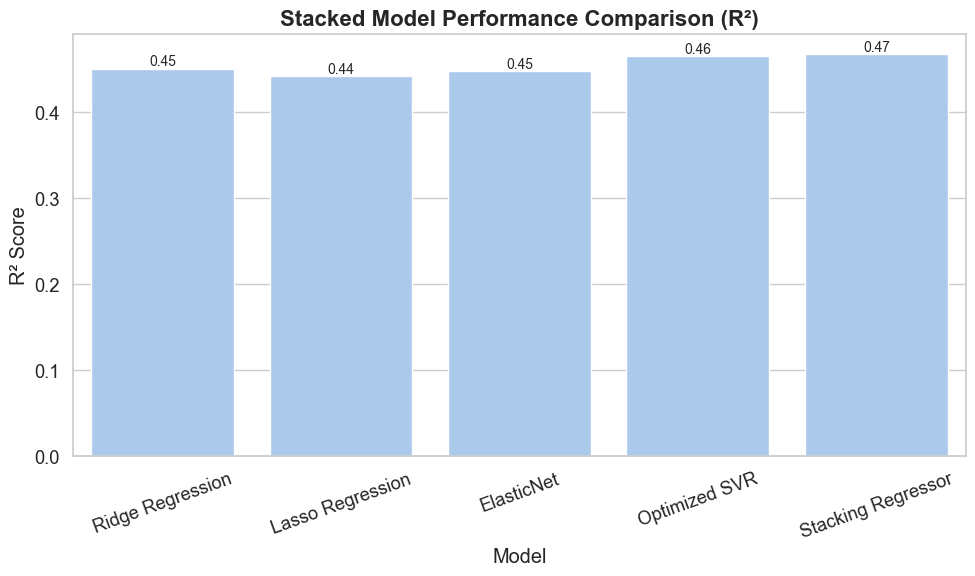

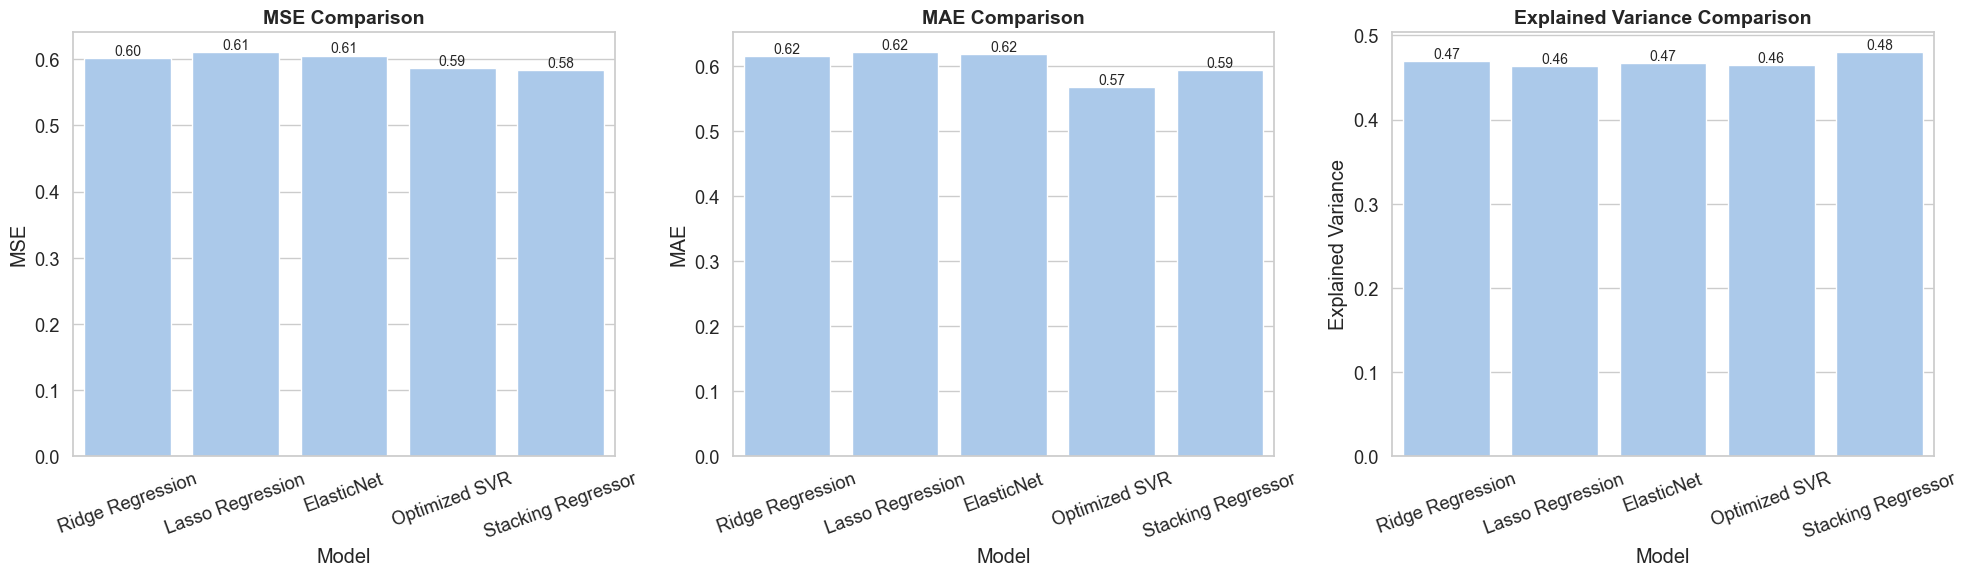

  0%|          | 0/43 [00:00<?, ?it/s]

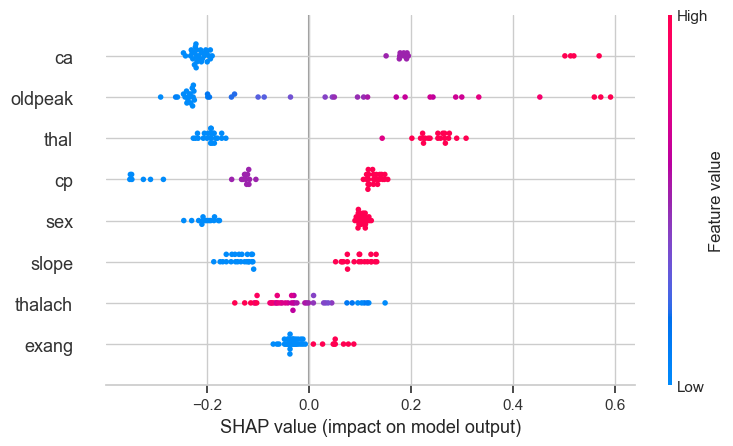

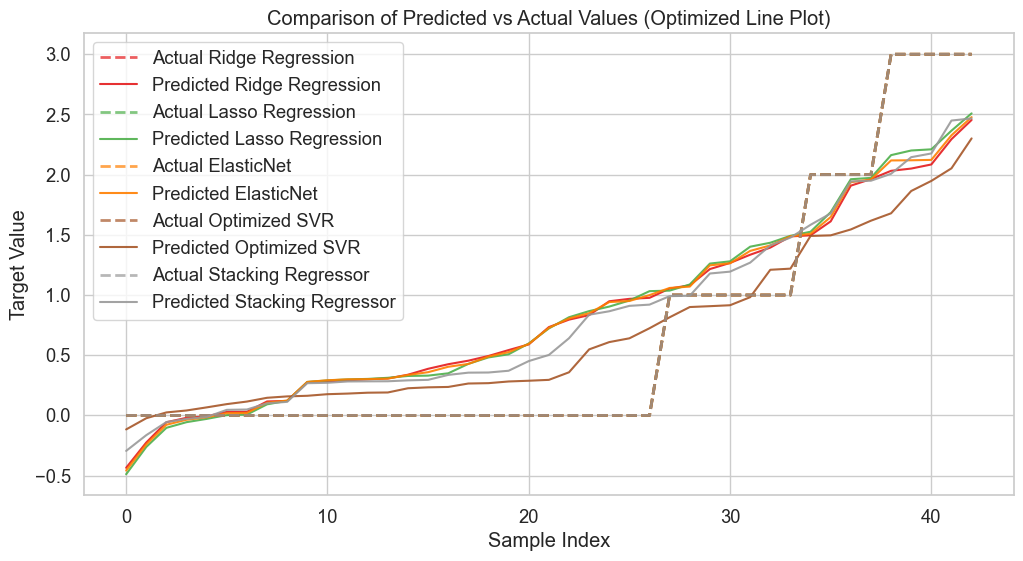

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression

#Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
data = pd.read_csv(url, names=columns)

#Handling of missing values
for col in ["ca", "thal"]:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna()

#Outlier handling
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
filtered_data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

#feature selection
X = filtered_data.drop(columns=["target"])
y = filtered_data["target"]
selector = SelectKBest(score_func=f_regression, k=8) 
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))

#standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Model setup
alphas = np.logspace(-4, 4, 20) 
base_models = [
    ('ridge', RidgeCV(alphas=alphas)),
    ('lasso', LassoCV(alphas=alphas, max_iter=10000)),
    ('elasticnet', ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.5, 0.9], max_iter=10000))
]

#Hyperparameter optimisation using GridSearch for SVRs
param_grid = {
    'C': [1, 5, 10, 20, 50],
    'epsilon': [0.01, 0.05, 0.1, 0.2],
    'gamma': ['scale', 'auto']
}
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters for SVR:", grid_search.best_params_)
optimized_svr = grid_search.best_estimator_
base_models.append(('svr', optimized_svr))

#Integration of multiple models Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=RidgeCV(alphas=alphas))
stacking_regressor.fit(X_train, y_train)

#Evaluate all models
models = {
    'Ridge Regression': base_models[0][1],
    'Lasso Regression': base_models[1][1],
    'ElasticNet': base_models[2][1],
    'Optimized SVR': optimized_svr,
    'Stacking Regressor': stacking_regressor
}

results = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2, 'MAE': mae, 'Explained Variance': evs}
    predictions[name] = y_pred
    print(f"{name}: MSE={mse:.4f}, R²={r2:.4f}, MAE={mae:.4f}, Explained Variance={evs:.4f}")

#Setting the global style
sns.set(style='whitegrid', palette='pastel', font_scale=1.2)

#Create Resulting DataFrame
results_df = pd.DataFrame(results).T

#Visualisation of results R²
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df, x=results_df.index, y='R²')

plt.title('Stacked Model Performance Comparison (R²)', fontsize=16, fontweight='bold')
plt.ylabel('R² Score')
plt.xlabel('Model')

#Setting scales and labels
ax.set_xticks(range(len(results_df.index)))
ax.set_xticklabels(results_df.index, rotation=20)

#Labelling of values on bar charts
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


#Results Visualisation MSE, MAE, Explained Variance
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
metrics = ['MSE', 'MAE', 'Explained Variance']
titles = ['MSE Comparison', 'MAE Comparison', 'Explained Variance Comparison']

for i, metric in enumerate(metrics):
    ax = sns.barplot(data=results_df, x=results_df.index, y=metric, ax=axes[i])
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)

    #Setting scales and labels
    ax.set_xticks(range(len(results_df.index)))
    ax.set_xticklabels(results_df.index, rotation=20)
    
    #Setting scales and labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#Explanatory model for SHAP value analysis
explainer = shap.KernelExplainer(stacking_regressor.predict, X_train[:100]) 
shap_values = explainer.shap_values(X_test[:50])  
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test[:50][0], feature_names=selected_features.tolist())
shap.summary_plot(shap_values, X_test[:50], feature_names=selected_features.tolist())

#Line graph showing predicted vs true value comparison
plt.figure(figsize=(12, 6))
colors = plt.cm.Set1(np.linspace(0, 1, len(models)))
for (name, y_pred), color in zip(predictions.items(), colors):
    plt.plot(range(len(y_test)), y_test.sort_values().values, label=f"Actual {name}", linestyle='dashed', linewidth=2, alpha=0.7, color=color)
    plt.plot(range(len(y_pred)), np.sort(y_pred), label=f"Predicted {name}", linestyle='solid', alpha=0.9, color=color)
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Comparison of Predicted vs Actual Values (Optimized Line Plot)")
plt.legend()
plt.show()